In [1]:
import geopandas as gpd
import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt
import numpy as np
from shapely.geometry import Polygon
from pathlib import Path
from shapely.geometry import box
import pandas as pd

In [2]:
data_dir = Path('../data/')
shapefile_path = data_dir / 'data_1/HABNAT/HABNATs.shp'
#one_tif_path = data_dir / 'zone48/230617_Ecomed_15cm_L93_4canaux_zone48_0_0.tif'
#one_tif_path = data_dir / 'zone48/230617_Ecomed_15cm_L93_4canaux_zone48_1_1.tif'
one_tif_path = data_dir / 'data_2/zone48/230617_Ecomed_15cm_L93_4canaux_zone48_0_0.tif'

### 1) Shapefile polygons: vector

In [5]:
shapefile = gpd.read_file(shapefile_path)

In [6]:
#print nb of unique values in shapefile in ID_Etude
print(shapefile['IDETUDE'].nunique())

114


In [13]:
print('With geopandas, the shapefile is loaded as a: ', type(shapefile))
# print('The type of the data in the shapefile is: ', shapefile.dtypes)
print('The number of polygons in the shapefile is: ', len(shapefile))

print('The shapefile has the keys: ', shapefile.columns)
# print('The shapefile has the following geometry: ', shapefile.geometry.name)
print('The shapefile has the crs: ', shapefile.crs)

With geopandas, the shapefile is loaded as a:  <class 'geopandas.geodataframe.GeoDataFrame'>
The number of polygons in the shapefile is:  11775
The shapefile has the keys:  Index(['ID', 'CDEUNIS_1', 'CDEUNIS', 'COMMENTAIR', 'CDCORIN_1', 'CDEUR_1',
       'LBEUNIS_1', 'LBCORIN_1', 'LBEUR_1', 'ETATCONS_1', 'TXRECOUV_1',
       'HABZH_1', 'CDEUNIS_2', 'CDCORIN_2', 'CDEUR_2', 'LBEUNIS_2',
       'LBCORIN_2', 'LBEUR_2', 'ETATCONS_2', 'TXRECOUV_2', 'HABZH_2',
       'CDEUNIS_3', 'CDCORIN_3', 'CDEUR_3', 'LBEUNIS_3', 'LBCORIN_3',
       'LBEUR_3', 'ETATCONS_3', 'TXRECOUV_3', 'HABZH_3', 'CDCORIN', 'CDEUR',
       'LIBEUNIS', 'LBEUR', 'LBPHYSIO', 'ETATCONS', 'HABZH', 'ENJEU', 'OBSERV',
       'SURFHA', 'IDETUDE', 'Shape_Leng', 'Shape_Area', 'geometry'],
      dtype='object')
The shapefile has the crs:  epsg:2154


In [6]:
# Is the key ID unique ? Is the key idetude unique ? 
print('The key ID is unique: ', shapefile['ID'].is_unique)
print('The key idetude is unique: ', shapefile['IDETUDE'].is_unique)

The key ID is unique:  False
The key idetude is unique:  False


In [10]:
# Add a unique id for each row 
shapefile['index'] = range(len(shapefile))

### 2) Tif images: raster

With rasterio, the tif image is loaded as a <class 'numpy.ndarray'>
The type of data in each band is:  uint16
The shape of the data is:  (4, 3982, 4084)
The tif image has the CRS:  LOCAL_CS["unnamed",UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]
Resolution: 0.15 by 0.15 meters
The range values of band 1 is:  828  to  16299 , the median is  1169.0
The range values of band 2 is:  896  to  16299 , the median is  1461.0
The range values of band 3 is:  33  to  16306 , the median is  1035.0
The range values of band 4 is:  1065  to  16326 , the median is  2603.0
With uint16, the range values is usually 0-65535
With uint8, the range values is usually 0-255
With float32, the range values is usually 0-1


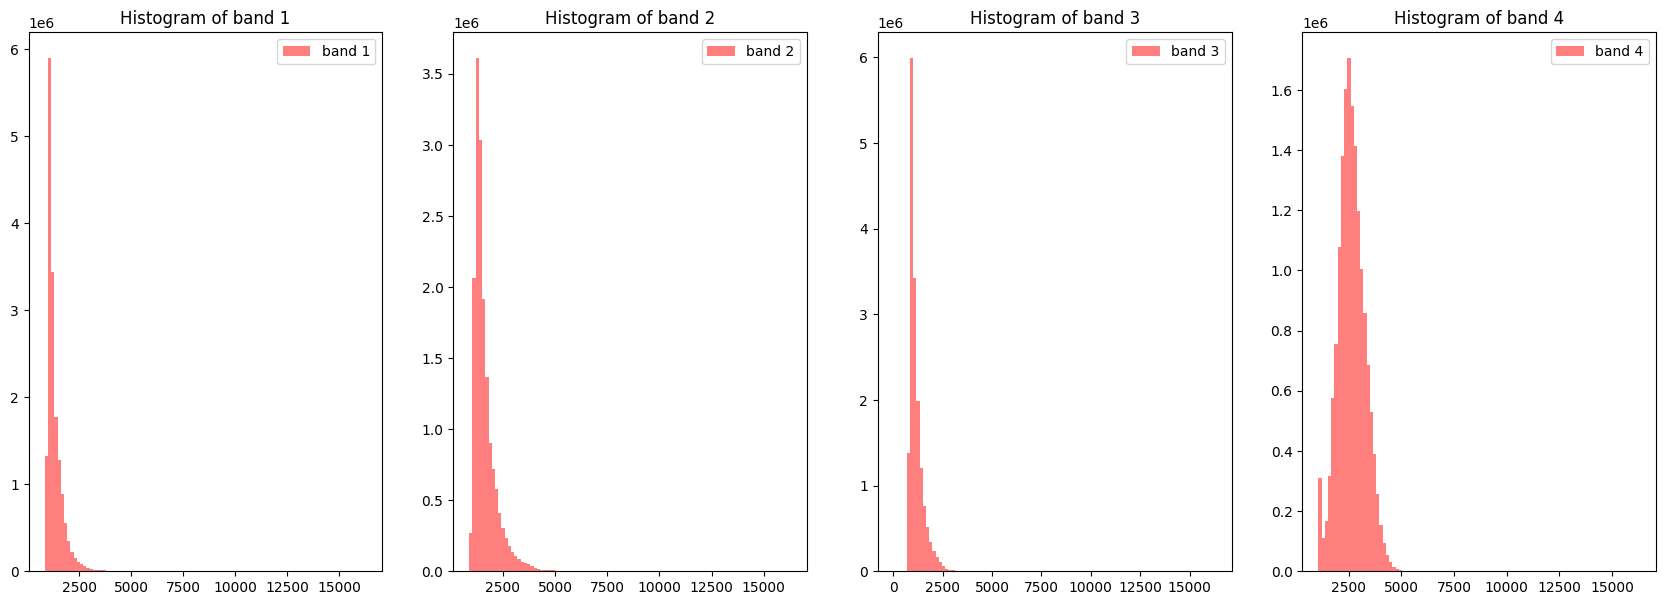

In [9]:
one_tif = rasterio.open(one_tif_path).read()

print('With rasterio, the tif image is loaded as a ' + str(type(one_tif)))
print('The type of data in each band is: ', one_tif.dtype)
print('The shape of the data is: ', one_tif.shape)

with rasterio.open(one_tif_path) as src:
    crs = src.crs
    x_res, y_res = src.res

print('The tif image has the CRS: ', crs)
print("Resolution: {} by {} meters".format(x_res, y_res))

rgb = one_tif#[0:3,:, :]

# Plot histogram of each band of rgb
fig, ax = plt.subplots(1, 4, figsize=(21, 7))
for i in range(4):
    ax[i].hist(rgb[i].ravel(), bins=100, color='red', alpha=0.5, label='band '+str(i+1))
    ax[i].legend()
    ax[i].set_title('Histogram of band '+str(i+1))
    print('The range values of band '+str(i+1)+' is: ', rgb[i].min(), ' to ', rgb[i].max(), ', the median is ', np.median(rgb[i]))

print('With uint16, the range values is usually 0-65535')
print('With uint8, the range values is usually 0-255')
print('With float32, the range values is usually 0-1')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


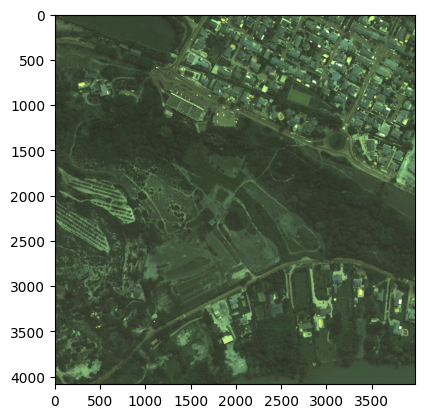

In [9]:
# Try to plot one tif image but problem with range of values

rgb = one_tif[0:3,:, :]
rgb = rgb/5000 # 5000 should be updated with the true value of the maximum value of the images. 
rgb = rgb.astype('float32')
#rgb = rgb[[0, 2, 1], :, :]
plt.imshow(rgb.transpose(2, 1, 0))
plt.show()

All the tif images do not have the same size. A cropping will be necessary to harmonise it in the pre-processing step. 

### 3) Intersection between shapefile polygons and tif images, some data are missing because corrupted. 

In [6]:
my_tif_paths = list(data_dir.rglob('*.tif'))
my_polygons = shapefile[['index', 'geometry']]

In [11]:
intersect = []

# check or valid polygons
my_polygons = my_polygons[my_polygons['geometry'].is_valid]

# Process each TIFF file
for tif_path in my_tif_paths:
    with rasterio.open(tif_path) as src:
        tif_bounds = src.bounds
        tif_box = box(*tif_bounds)  # Convert BoundingBox to shapely box

    # Check each polygon
    for index, polygon in my_polygons.iterrows():
        geom = polygon['geometry']
        if geom is not None and tif_box.intersects(geom):
            intersection = tif_box.intersection(geom)
            intersection_percentage = intersection.area / geom.area

            # Check if the intersection is greater than 75%
            if intersection_percentage > 0.75:
                #print(f'The polygon with index {polygon["index"]} intersects significantly with {tif_path.name}')
                intersect.append({
                    'tif_path': tif_path,
                    'polygon_index': polygon['index'],
                    'intersection_percentage': intersection_percentage
                })

# Convert results to DataFrame
intersect_df = pd.DataFrame(intersect)
print(intersect_df)

intersect_df.to_csv('intersection_shp_tif.csv', index=False)

                                               tif_path  polygon_index  \
0     ../data/data_1/zone26/230617_Ecomed_15cm_L93_4...           4114   
1     ../data/data_1/zone26/230617_Ecomed_15cm_L93_4...           4115   
2     ../data/data_1/zone26/230617_Ecomed_15cm_L93_4...           4116   
3     ../data/data_1/zone26/230617_Ecomed_15cm_L93_4...           4117   
4     ../data/data_1/zone26/230617_Ecomed_15cm_L93_4...           4118   
...                                                 ...            ...   
8606  ../data/data_4/zone172/230617_Ecomed_15cm_L93_...           8585   
8607  ../data/data_4/zone172/230617_Ecomed_15cm_L93_...           8586   
8608  ../data/data_4/zone172/230617_Ecomed_15cm_L93_...           8587   
8609  ../data/data_4/zone172/230617_Ecomed_15cm_L93_...           8588   
8610  ../data/data_4/zone172/230617_Ecomed_15cm_L93_...           8589   

      intersection_percentage  
0                         1.0  
1                         1.0  
2              

In [35]:
per_polygons_kept = round(len(intersect_df['polygon_index'].unique()) * 100 / len(my_polygons), 2)
print('The percentage of polygons we kept from the original number of polygons is', per_polygons_kept)

per_images_kept = round(len(intersect_df['tif_path'].unique()) * 100 / len(my_tif_paths), 2)
print('The percentage of images we kept from the original total of tif images is', per_images_kept)

The percentage of polygons we kept from the original number of polygons is 73.6
The percentage of images we kept from the original total of tif images is 55.84


In [27]:
# load intersect_df from csv
intersect_df = pd.read_csv('../csv/intersection_shp_tif.csv')

In [28]:
# Filter the data
filtered_shapefile = shapefile[shapefile['index'].isin(intersect_df['polygon_index'])]
filtered_tif_paths = intersect_df['tif_path'].unique()

In [11]:
print('Before filtering, we had ', len(shapefile), ' polygons and ', len(my_tif_paths), ' tif images')
print('After filtering, we have ', len(filtered_shapefile), ' polygons and ', len(filtered_tif_paths), ' tif images')

Before filtering, we had  11775  polygons and  634  tif images
After filtering, we have  8479  polygons and  354  tif images


In [13]:
# print the shape of the first 10 images
for tif_path in filtered_tif_paths[:10]:
    with rasterio.open(tif_path) as src:
        print(src.shape)

(3731, 4594)
(5940, 5897)
(6195, 8808)
(6208, 5255)
(6208, 8808)
(2293, 1831)
(9080, 9162)
(9080, 10000)
(10000, 10000)
(10000, 10000)


In [15]:
# histograms of size of images
images_shape = []
for tif_path in filtered_tif_paths:
    with rasterio.open(tif_path) as src:
        images_shape.append(src.shape)

images_shape = np.array(images_shape)

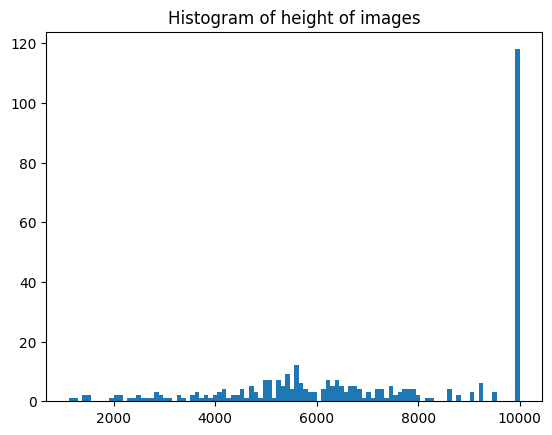

The median of the height of the images is  6886.0
The first quartile of the height of the images is  5313.0
The third quartile of the height of the images is  10000.0


In [18]:
# histogram of height. 
plt.hist(images_shape[:, 0], bins=100)
plt.title('Histogram of height of images')
plt.show()

# get median and first quartile and second quartile
print('The median of the height of the images is ', np.median(images_shape[:, 0]))
print('The first quartile of the height of the images is ', np.percentile(images_shape[:, 0], 25))
print('The third quartile of the height of the images is ', np.percentile(images_shape[:, 0], 75))

In [22]:
# The percentages of images with height = 100 is 
print('The percentage of images with height = 10000 is', round(len(images_shape[images_shape[:, 0] == 10000]) * 100 / len(images_shape), 2))

The percentage of images with height = 10000 is 33.33


## Statistics
### 1) Surfaces

50% of the surfaces are between 0 and 1032 m2, 50% are between 1032 and 386734 m2.
25% of the surfaces are below 287 m2.
75% of the surfaces are above 3751 m2.
05% of the surfaces are below 25 m2.
95% of the surfaces are below 19733 m2, it means that only 5% of the surfaces are between 19733 and 386734 m2.
Mean Area: 4944


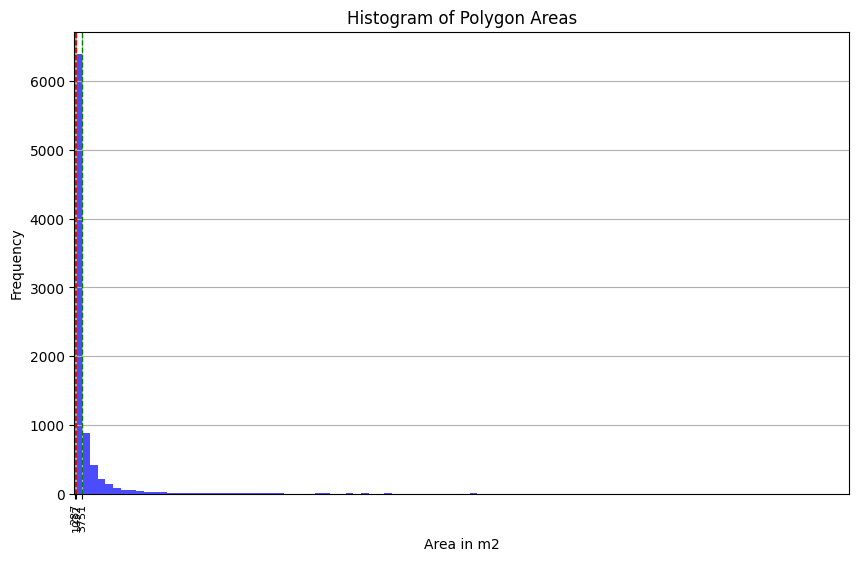

In [7]:
mean_area = round(filtered_shapefile['Shape_Area'].mean())
median_area = round(filtered_shapefile['Shape_Area'].median())
first_quantile = round(filtered_shapefile['Shape_Area'].quantile(0.25))
third_quantile = round(filtered_shapefile['Shape_Area'].quantile(0.75))

quin1_quantile = round(filtered_shapefile['Shape_Area'].quantile(0.05))
quin2_quantile = round(filtered_shapefile['Shape_Area'].quantile(0.95))

std_area = round(filtered_shapefile['Shape_Area'].std())
min_area = round(filtered_shapefile['Shape_Area'].min())
max_area = round(filtered_shapefile['Shape_Area'].max())

#print(f"Minimum Area: {min_area}")
#print(f"Maximum Area: {max_area}")

print('50% of the surfaces are between ' + str(min_area) + ' and ' + str(median_area) + ' m2, 50% are between ' + str(median_area) + ' and ' + str(max_area) + ' m2.')
print('25% of the surfaces are below ' + str(first_quantile) + ' m2.')
print('75% of the surfaces are above ' + str(third_quantile) + ' m2.')
print('05% of the surfaces are below ' + str(quin1_quantile) + ' m2.')
print('95% of the surfaces are below ' + str(quin2_quantile) + ' m2, it means that only 5% of the surfaces are between ' + str(quin2_quantile) + ' and ' + str(max_area) + ' m2.')

print(f"Mean Area: {mean_area}")
#print(f"Standard Deviation of Area: {std_area}")

plt.figure(figsize=(10, 6))
plt.hist(filtered_shapefile['Shape_Area'], bins=100, color='blue', alpha=0.7)
plt.title('Histogram of Polygon Areas')
plt.xlabel('Area in m2')
plt.ylabel('Frequency')
plt.axvline(median_area, color='red', linestyle='dashed', linewidth=1)
plt.axvline(first_quantile, color='green', linestyle='dashed', linewidth=1)
plt.axvline(third_quantile, color='green', linestyle='dashed', linewidth=1)
# add ticks values doir axline and dtart x at 0
plt.xlim(min_area, max_area)
plt.xticks([first_quantile, median_area, third_quantile], rotation=90, fontsize=8)
plt.grid(True)
plt.show()

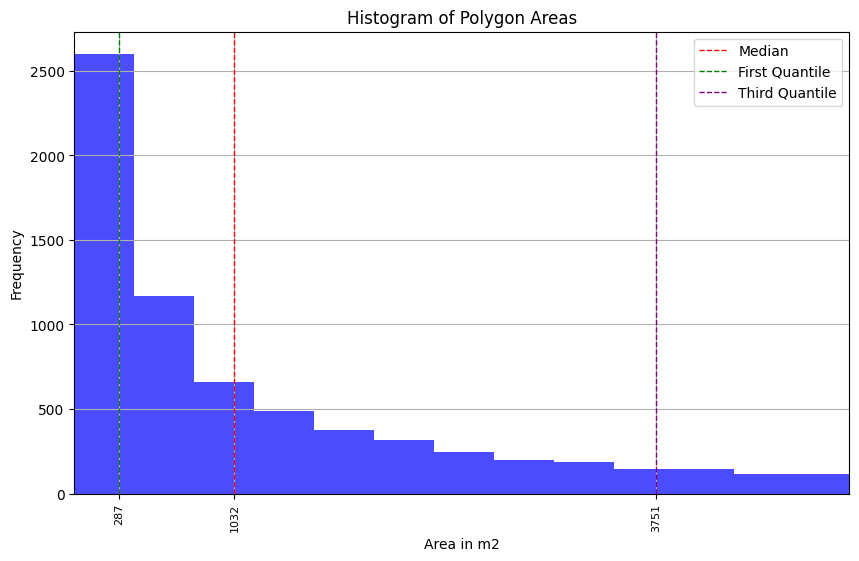

In [8]:
# For more visibility, let us truncate the x axis
plt.figure(figsize=(10, 6))
plt.xlim(min_area, 5000)
plt.hist(filtered_shapefile['Shape_Area'], bins=1000, color='blue', alpha=0.7)
plt.title('Histogram of Polygon Areas')
plt.xlabel('Area in m2')
plt.ylabel('Frequency')
plt.axvline(median_area, color='red', linestyle='dashed', linewidth=1, label='Median')
plt.axvline(first_quantile, color='green', linestyle='dashed', linewidth=1, label='First Quantile')
plt.axvline(third_quantile, color='purple', linestyle='dashed', linewidth=1, label='Third Quantile')
plt.legend()
# add ticks values doir axline and dtart x at 0
plt.xticks([first_quantile, median_area, third_quantile], rotation=90, fontsize=8)
plt.grid(True)
plt.show()

In [63]:
nb_pixels = round(25 / (0.15*0.15))
print("25m2 represents 25 / 0.15**2 = ", nb_pixels, "pixels")
per_image = round(nb_pixels * 100 / (4000*4000), 4)
print("It represents approximately ", per_image, "% of the tif image we studied at the beginning. Note that all images do not have the same size.")

25m2 represents 25 / 0.15**2 =  1111 pixels
0.0069
It represents  0.0069 % of the tif image we studied at the begining. Note that images do not have the same size.


In [22]:
print('300m2 represents ', round(300 / (0.15*0.15)), ' pixels')
print('It represents approximately ', (13333*100 / (4000*4000), 4), '% of the tif image we studied at the beginning. Note that all images do not have the same size.')

300m2 represents  13333  pixels
It represents approximately  (0.08333125, 4) % of the tif image we studied at the beginning. Note that all images do not have the same size.


### 2) Classes proportions

In [65]:
# get proportions of classes at first level in shapefile_filtered
first_level_classes = filtered_shapefile['NOM_HAB'].value_counts(normalize=True)
print(first_level_classes)


          ID CDEUNIS_1           CDEUNIS COMMENTAIR CDCORIN_1 CDEUR_1  \
0         17      G5.2              G5.2       None      None    None   
1         18      J4.2              J4.2       None      None       -   
2         19      FB.4              FB.4       None     83.21       -   
3         20     I1.53             I1.53       None      None       -   
4         21      G5.2              G5.2       None      None    None   
...      ...       ...               ...        ...       ...     ...   
11769     67    F5.113  F5.113 x F5.1162       None    32.113       -   
11770  23270    E1.311  E1.311 x F5.1162       None    34.511   6220*   
11771  23246      J4.2              J4.2       None      None       -   
11772  23270    E1.311  E1.311 x F5.1162       None    34.511   6220*   
11773  23246      J4.2              J4.2       None      None       -   

                                               LBEUNIS_1  \
0      Petits bois anthropiques de feuillus caducifoliés   
1  

In [92]:
# print each key value of the first item of shapefile, at a new row
for key, value in filtered_shapefile.iloc[57].items():
    print(key, value)

# print area computed
print(filtered_shapefile.iloc[57]['geometry'].area)

ID 79
CDEUNIS_1 I1.53
CDEUNIS I1.53
COMMENTAIR None
CDCORIN_1 None
CDEUR_1 -
LBEUNIS_1 Jachères non inondées avec communautés rudérales annuelles ou vivaces
LBCORIN_1 -
LBEUR_1 -
ETATCONS_1 Mauvais
TXRECOUV_1 100
HABZH_1 -
CDEUNIS_2 None
CDCORIN_2 None
CDEUR_2 None
LBEUNIS_2 None
LBCORIN_2 None
LBEUR_2 None
ETATCONS_2 None
TXRECOUV_2 0
HABZH_2 None
CDEUNIS_3 None
CDCORIN_3 None
CDEUR_3 None
LBEUNIS_3 None
LBCORIN_3 None
LBEUR_3 None
ETATCONS_3 None
TXRECOUV_3 0
HABZH_3 None
CDCORIN None
CDEUR None
LIBEUNIS Jachères non inondées avec communautés rudérales annuelles ou vivaces
LBEUR None
LBPHYSIO Friches
ETATCONS Mauvais
HABZH None
ENJEU Faible
OBSERV Teddy BAUMBERGER
SURFHA 0.6763595357
IDETUDE 2204
Shape_Leng 402.34994485
Shape_Area 6763.595357
geometry POLYGON ((901269.9751000032 6291989.497699998, 901268.8588000014 6291987.376800001, 901263.5260000005 6291985.494600002, 901265.4081000015 6291981.102899998, 901262.2712000012 6291979.2206999995, 901260.0753000006 6291982.984999999, 901

In [78]:
# keep id = 3
shapefile_id3 = filtered_shapefile[filtered_shapefile['ID'] == 3]
for key, group in shapefile_id3.groupby('ID'):
    print(key)
    print(group)

3
       ID CDEUNIS_1        CDEUNIS COMMENTAIR CDCORIN_1 CDEUR_1  \
794     3      J4.2           J4.2       None      None       -   
1566    3     G1.71  G1.71 x E1.31       None     41.71       -   
1684    3     C1.14          C1.14       None     22.44    3140   
1698    3     C1.14          C1.14       None     22.44    3140   
2147    3     C3.21  C3.21 x G1.31       None     53.11       -   
3101    3      E5.1           E5.1       None      None       -   
3346    3      J2.3           J2.3       None      None       -   
4008    3      E5.1    E3.1xG1.711       None      None       -   
4012    3      H5.6           H5.6       None      None       -   
4154    3      J4.2           J4.2       None      None       -   
6152    3     B1.43          B1.43       None    16.223    2210   
7767    3      E5.1           E5.1       None      None       -   
8872    3     G3.74          G3.74       None     42.84    9540   
8902    3      J4.2           None       None      None     

In [91]:
# the class at the corsest level is the first letter in the attribute CDEUNIS
my_classes = filtered_shapefile['CDEUNIS'].apply(lambda x: x[0] if x is not None else None)
# unique 
my_classes = my_classes.unique()
# remove None
my_classes = my_classes[~pd.isnull(my_classes)]
# sort
my_classes = sorted(my_classes)
# order by alphabetical order
print(my_classes)

['1', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'X']


In [9]:
my_classes_l1 = {
    'A': 'Habitats marins', 
    'B': 'Habitats cotiers',
    'C': 'Eaux de surfaces continentales',
    'D': 'Tourbieres et bas-marais',
    'E': 'Prairies, terrains domines par des especes non graminoides, des mousses ou des lichens',
    'F': 'Landes, fourres et toundras',
    'G': 'Bois, forets et autres habitats boises',
    'H': 'Habitats continentaux sans vegetation ou à vegetation clairsemee',
    'I': 'Habitats agricoles, horticoles et domestiques régulierement ou recemment cultives',
    'J': 'Zones baties, sites industriels et autres habitats artificiels',
    'X': 'Complexes d habitats', 
    '1': 'Annotation error ?',
}

In [ ]:
my_classes_l2 = {
    'A1': 'Habitats marins', 

In [82]:
# look for a row with TXRECOUV_1 < 100 and plot its key and value
for key, value in filtered_shapefile[filtered_shapefile['TXRECOUV_1'] < 100].iloc[0].items():
    print(key, value)

ID 58
CDEUNIS_1 E1.2A
CDEUNIS E1.2A x F3.1
COMMENTAIR None
CDCORIN_1 34.36
CDEUR_1 -
LBEUNIS_1 Pelouses à [Brachypodium phoenicoides]
LBCORIN_1 gazons à Brachypode de Phénicie
LBEUR_1 -
ETATCONS_1 Mauvais
TXRECOUV_1 70
HABZH_1 -
CDEUNIS_2 F3.1
CDCORIN_2 31.8
CDEUR_2 -
LBEUNIS_2 Fourrés tempérés
LBCORIN_2 Fourrés
LBEUR_2 -
ETATCONS_2 None
TXRECOUV_2 30
HABZH_2 p
CDEUNIS_3 None
CDCORIN_3 None
CDEUR_3 None
LBEUNIS_3 None
LBCORIN_3 None
LBEUR_3 None
ETATCONS_3 None
TXRECOUV_3 0
HABZH_3 None
CDCORIN 34.36 x 31.8
CDEUR - x -
LIBEUNIS Pelouses à [Brachypodium phoenicoides] x Fourrés tempérés
LBEUR - x -
LBPHYSIO Pelouses à Brachypode de Phénicie embroussaillées
ETATCONS Mauvais
HABZH - x p x
ENJEU Faible
OBSERV JÃ©rÃ´me VOLANT
SURFHA 0.922892174898
IDETUDE 2204
Shape_Leng 540.959358774
Shape_Area 9228.92174898
geometry POLYGON ((901183.5571999997 6292116.239700001, 901146.5254999995 6292087.143300001, 901125.3922000006 6292131.577300001, 901094.5051999986 6292116.4047, 901021.3515999988 62922

#### Percentages of mixed areas. 

In [93]:
# Select rows with cov < 100, count the cumulated areas, and compare it with the total areas 
total_area = filtered_shapefile['geometry'].area.sum()
cumulated_area = filtered_shapefile[filtered_shapefile['TXRECOUV_1'] < 100]['geometry'].area.sum()
print('The cumulated area of polygons with TXRECOUV_1 < 100 is ', cumulated_area)
print('The total area of polygons is ', total_area)
print('The cumulated area of polygons with TXRECOUV_1 < 100 is ', round(cumulated_area * 100 / total_area, 2), '% of the total area of polygons')

The cumulated area of polygons with TXRECOUV_1 < 100 is  36362475.88004361
The total area of polygons is  41916512.6773266
The cumulated area of polygons with TXRECOUV_1 < 100 is  86.75 % of the total area of polygons


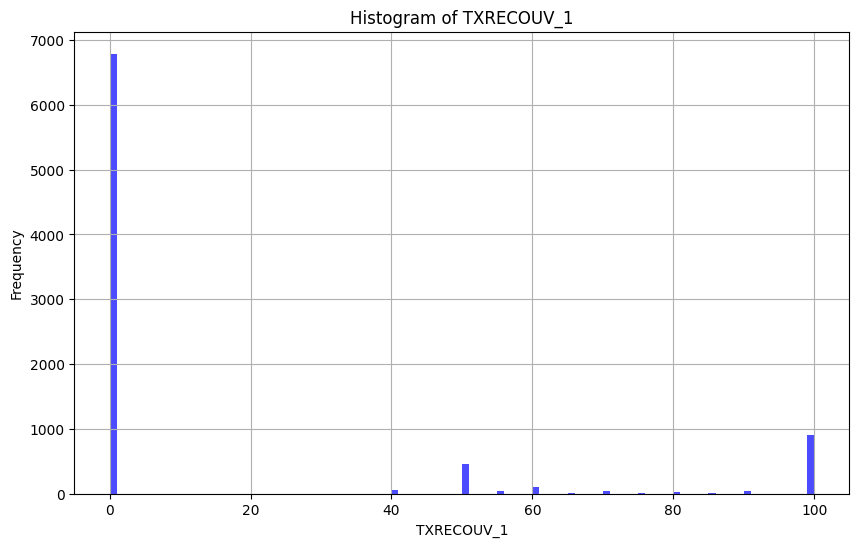

In [122]:
# histogram of TX_RECOUVR_1
plt.figure(figsize=(10, 6))
plt.hist(filtered_shapefile['TXRECOUV_1'], bins=100, color='blue', alpha=0.7)
plt.title('Histogram of TXRECOUV_1')
plt.xlabel('TXRECOUV_1')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [123]:
# count percentages of polygons with TX_RECOUV_1 == 0 
per_0 = round(len(filtered_shapefile[filtered_shapefile['TXRECOUV_1'] == 0]) * 100 / len(filtered_shapefile), 2)
print('The percentage of polygons with TXRECOUV_1 == 0 is ', per_0, '%')
print('Among the polygons with TXRECOUV_1 == 0, some of them are "pure" and others not. ')

# count polygons with TXRECOUV_1 == 0
len_recouv_null = len(filtered_shapefile[filtered_shapefile['TXRECOUV_1'] == 0])

# count polyfonw with TXRECOUV_1 == 0 and CDEUNIS_2 None
recouv_100_but_marked_as_0 = len(filtered_shapefile[(filtered_shapefile['TXRECOUV_1'] == 0) & pd.isnull(filtered_shapefile['CDEUNIS_2'])])

mixed_lc_recouv_unknown = len_recouv_null - recouv_100_but_marked_as_0

The percentage of polygons with TXRECOUV_1 == 0 is  80.04 %
Among the polygons with TXRECOUV_1 == 0, some of them are "pure" and others not. 


In [124]:
print('Among the polygons with recouvrement rate at 0, some of them have registered only one land cover (CDEUNIS_2 is None). In this case we think 0 should be 100. ')
print('It represents ', round(recouv_100_but_marked_as_0 * 100 / len_recouv_null, 2), '% of the polygons with recouvrement rate at 0. ')
print('The other polygons with recouvrement rate at 0 have several land covers (CDEUNIS_2 is not None)')
print('It represents ', round(mixed_lc_recouv_unknown * 100 / len_recouv_null, 2), '% of the polygons with recouvrement rate at 0. ')

Among the polygons with recouvrement rate at 0, some of them have registered only one land cover (CDEUNIS_2 is None). In this case we think 0 should be 100. 
It represents  81.29 % of the polygons with recouvrement rate at 0. 
The other polygons with recouvrement rate at 0 have several land covers (CDEUNIS_2 is not None)
It represents  18.71 % of the polygons with recouvrement rate at 0. 


In [130]:
# for shapefile, with TXRECOUV_1 = 0 and CDEUNIS_2 = None, check values unique of TXRECOUV_2, CDEUNIS_3 and TXRECOUV_3
recouv_100_but_marked_as_0_df = filtered_shapefile[(filtered_shapefile['TXRECOUV_1'] == 0) & pd.isnull(filtered_shapefile['CDEUNIS_2'])]
print(recouv_100_but_marked_as_0_df['TXRECOUV_2'].unique())
print(recouv_100_but_marked_as_0_df['CDEUNIS_3'].unique())
print(recouv_100_but_marked_as_0_df['TXRECOUV_3'].unique())

# print the rows with TXRECOUV_2 == 30
for key, value in recouv_100_but_marked_as_0_df[recouv_100_but_marked_as_0_df['TXRECOUV_2'] == 30].iloc[0].items():
    if key in ['CDEUNIS', 'CDEUNIS_1', 'TXRECOUV_1', 'CDEUNIS_2', 'TXRECOUV_2', 'CDEUNIS_3', 'TXRECOUV_3', 'Shape_Area']:
        print(key, value)

# count the rows with TXRECOUV_2 == 30
len_30 = len(recouv_100_but_marked_as_0_df[recouv_100_but_marked_as_0_df['TXRECOUV_2'] == 30])
print('The number of polygons with TXRECOUV_2 == 30 is ', len_30)

print('One row has covering rate 1 set to 0, CDEUNIS_1 set to J4.2, covering rate 2 set to 30 but CD_EUNIS_2 set to None. ')
# drop it
recouv_100_but_marked_as_0_df = recouv_100_but_marked_as_0_df[recouv_100_but_marked_as_0_df['TXRECOUV_2'] != 30]

[ 0 30]
[None]
[0]
CDEUNIS_1 J4.2
CDEUNIS J4.2
TXRECOUV_1 0
CDEUNIS_2 None
TXRECOUV_2 30
CDEUNIS_3 None
TXRECOUV_3 0
Shape_Area 964.607479064
The number of polygons with TXRECOUV_2 == 30 is  1
One row has covering rate 1 set to 0, CDEUNIS_1 set to J4.2, covering rate 2 set to 30 but CD_EUNIS_2 set to None. 


In [29]:
# Turn all recouvrement rates at 0 to 100 when CDEUNIS_2 is None in filtered_shapefile
filtered_shapefile.loc[(filtered_shapefile['TXRECOUV_1'] == 0) & pd.isnull(filtered_shapefile['CDEUNIS_2']), 'TXRECOUV_1'] = 100

In [98]:
print('Taux recouvrement = 100: ')
for key, value in filtered_shapefile[filtered_shapefile['TXRECOUV_1'] == 100].iloc[0].items():
    #print only CDEUNIS, CDEUNIS_1, TXRECOUV_1, CDEUNIS_2, TXRECOUV_2, CDEUNIS_3, TXRECOUV_3, Shape_Area
    if key in ['CDEUNIS', 'CDEUNIS_1', 'TXRECOUV_1', 'CDEUNIS_2', 'TXRECOUV_2', 'CDEUNIS_3', 'TXRECOUV_3', 'Shape_Area']:
        print(key, value)
print('----------------------------------')
print('Taux recouvrement = 0: ')
for key, value in filtered_shapefile[filtered_shapefile['TXRECOUV_1'] == 0].iloc[100].items():
    #print only CDEUNIS, CDEUNIS_1, TXRECOUV_1, CDEUNIS_2, TXRECOUV_2, CDEUNIS_3, TXRECOUV_3, Shape_Area
    if key in ['CDEUNIS', 'CDEUNIS_1', 'TXRECOUV_1', 'CDEUNIS_2', 'TXRECOUV_2', 'CDEUNIS_3', 'TXRECOUV_3', 'Shape_Area']:
        print(key, value)
print('----------------------------------')
print('Taux recouvrement entre 20 et 80: ')
# > 20 and < 80
for key, value in filtered_shapefile[(filtered_shapefile['TXRECOUV_1'] > 20) & (filtered_shapefile['TXRECOUV_1'] < 80)].iloc[0].items():
    #print only CDEUNIS, CDEUNIS_1, TXRECOUV_1, CDEUNIS_2, TXRECOUV_2, CDEUNIS_3, TXRECOUV_3, Shape_Area
    if key in ['CDEUNIS', 'CDEUNIS_1', 'TXRECOUV_1', 'CDEUNIS_2', 'TXRECOUV_2', 'CDEUNIS_3', 'TXRECOUV_3', 'Shape_Area']:
        print(key, value)

Taux recouvrement = 100: 
CDEUNIS_1 G5.2
CDEUNIS G5.2
TXRECOUV_1 100
CDEUNIS_2 None
TXRECOUV_2 0
CDEUNIS_3 None
TXRECOUV_3 0
Shape_Area 137.813736692
----------------------------------
Taux recouvrement = 0: 
CDEUNIS_1 E1.61
CDEUNIS E1.61 x F3.22
TXRECOUV_1 0
CDEUNIS_2 F3.22
TXRECOUV_2 0
CDEUNIS_3 None
TXRECOUV_3 0
Shape_Area 163.058486602
----------------------------------
Taux recouvrement entre 20 et 80: 
CDEUNIS_1 E1.2A
CDEUNIS E1.2A x F3.1
TXRECOUV_1 70
CDEUNIS_2 F3.1
TXRECOUV_2 30
CDEUNIS_3 None
TXRECOUV_3 0
Shape_Area 9228.92174898


In [102]:
# select all rows for which TXRECOUV is 0
subset = filtered_shapefile[(filtered_shapefile['TXRECOUV_1'] == 0)]
print('The number of polygons with TXRECOUV_1 = 0 is ', len(subset))
# check if CDEUNIS_2 is not None
subset = subset[pd.isnull(subset['CDEUNIS_2'])]
print('The number of polygons with TXRECOUV_1 = 0 and CDEUNIS_2 is not None is ', len(subset))

for key, value in subset.iloc[0].items():
    if key in ['CDEUNIS', 'CDEUNIS_1', 'TXRECOUV_1', 'CDEUNIS_2', 'TXRECOUV_2', 'CDEUNIS_3', 'TXRECOUV_3', 'Shape_Area']:
        print(key, value)

The number of polygons with TXRECOUV_1 = 0 is  6787
The number of polygons with TXRECOUV_1 = 0 and CDEUNIS_2 is not None is  5517
CDEUNIS_1 J4.2
CDEUNIS J4.2
TXRECOUV_1 0
CDEUNIS_2 None
TXRECOUV_2 0
CDEUNIS_3 None
TXRECOUV_3 0
Shape_Area 1279.96400762


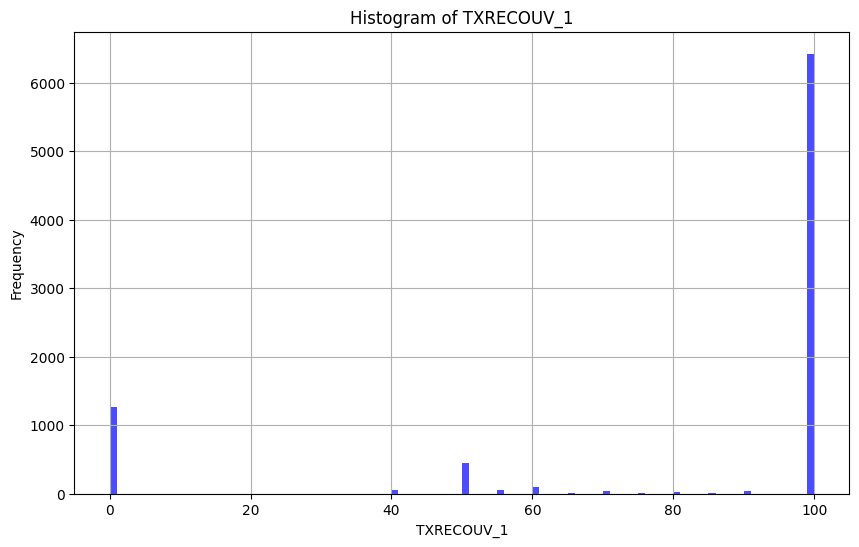

In [133]:
# histogram of TX_RECOUVR_1
plt.figure(figsize=(10, 6))
plt.hist(filtered_shapefile['TXRECOUV_1'], bins=100, color='blue', alpha=0.7)
plt.title('Histogram of TXRECOUV_1')
plt.xlabel('TXRECOUV_1')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [169]:
total_area = filtered_shapefile['Shape_Area'].sum()
per_area_single_class = round((filtered_shapefile[filtered_shapefile['TXRECOUV_1'] == 100]['Shape_Area'].sum() * 100 ) / total_area)

mixed_area = filtered_shapefile[filtered_shapefile['TXRECOUV_1'] < 100]['Shape_Area'].sum()
per_area_multiple_class = round(mixed_area * 100 / total_area)
                                
print('On the total surface covered by the polygons, ' + str(per_area_single_class) + '% is labelled with a single class (TXRECOUV_1 = 100), ')
print(str(per_area_multiple_class) + '% is labelled with multiple classes (TXRECOUV_1 < 100). ')

unknown_cover = round(filtered_shapefile[filtered_shapefile['TXRECOUV_1'] == 0]['Shape_Area'].sum() * 100 / mixed_area)
unknown_cover_tot = round(filtered_shapefile[filtered_shapefile['TXRECOUV_1'] == 0]['Shape_Area'].sum() * 100 / total_area)

print('Among the surfaces assigned with multiple classes, ' + str(unknown_cover) + '% has uknown proportion of coverage (TXRECOUV_1 = 0). ') 
print('It represents ' + str(unknown_cover_tot) + '% of all the areas. ')

On the total surface covered by the polygons, 69% is labelled with a single class (TXRECOUV_1 = 100), 
30.792884679030234% is labelled with multiple classes (TXRECOUV_1 < 100). 
Among the surfaces assigned with multiple classes, 58% has uknown proportion of coverage (TXRECOUV_1 = 0). 
It represents 18% of all the areas. 


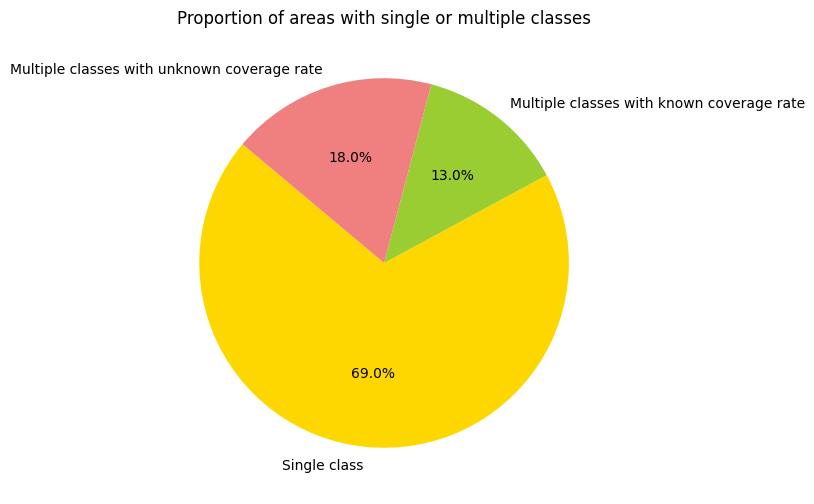

In [174]:
mixed_area_known = filtered_shapefile[(filtered_shapefile['TXRECOUV_1'] < 100) & (filtered_shapefile['TXRECOUV_1'] > 0)]['Shape_Area'].sum()
per_area_multiple_class_known = round(mixed_area_known * 100  / total_area)

# pie plot with per_area_multiple_class_known, uknown cover and per_area_single_class
plt.figure(figsize=(10, 6))
labels=['Single class', 'Multiple classes with known coverage rate', 'Multiple classes with unknown coverage rate']
sizes=[per_area_single_class, per_area_multiple_class_known, unknown_cover_tot]
colors=['gold', 'yellowgreen', 'lightcoral']
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.title('Proportion of areas with single or multiple classes')
plt.show()

The proportion of area with 2 classes CDEUNIS_1, CDEUNIS_2 not None and CDEUNIS_3 None is  19 %
The proportion of area with 3 classes CDEUNIS_1, CDEUNIS_2 and CDEUNIS_3 not None is  12 %


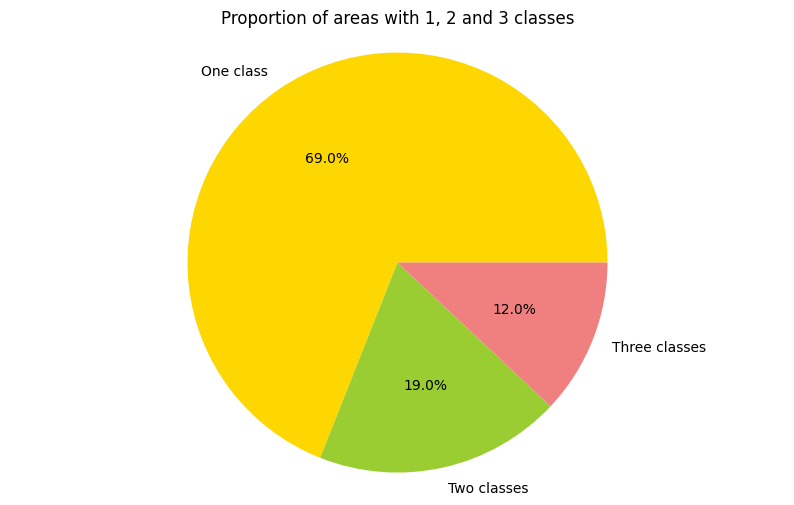

In [159]:
# Proportion of area with 2 classes CDEUNIS_1, CDEUNIS_2 not None and CDEUNIS_3 None
per_two_classes = round(filtered_shapefile[(filtered_shapefile['TXRECOUV_1'] < 100) & pd.notnull(filtered_shapefile['CDEUNIS_2']) & pd.isnull(filtered_shapefile['CDEUNIS_3'])]['Shape_Area'].sum() * 100 / total_area)
print('The proportion of area with 2 classes CDEUNIS_1, CDEUNIS_2 not None and CDEUNIS_3 None is ', per_two_classes, '%')

# Proportion of area with 3 classes CDEUNIS_1, CDEUNIS_2 and CDEUNIS_3 not None
per_three_classes = round(filtered_shapefile[(filtered_shapefile['TXRECOUV_1'] < 100) & pd.notnull(filtered_shapefile['CDEUNIS_2']) & pd.notnull(filtered_shapefile['CDEUNIS_3'])]['Shape_Area'].sum() * 100 / total_area)
print('The proportion of area with 3 classes CDEUNIS_1, CDEUNIS_2 and CDEUNIS_3 not None is ', per_three_classes, '%')

#make a pie plot. Percentage of 1 class, 2 classes, 3 classes
plt.figure(figsize=(10, 6))
labels = ['One class', 'Two classes', 'Three classes']
sizes = [per_area_single_class, per_two_classes, per_three_classes]
colors = ['gold', 'yellowgreen', 'lightcoral']
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%')
plt.axis('equal')
plt.title('Proportion of areas with 1, 2 and 3 classes')
plt.show()

In [162]:
# select all areas with mixed classes
mixed_classes = filtered_shapefile[filtered_shapefile['TXRECOUV_1'] < 100]
# keep only CDEUNIS_1, CDEUNIS_2 and CDEUNIS_3
mixed_classes = mixed_classes[['CDEUNIS_1', 'CDEUNIS_2', 'CDEUNIS_3', 'Shape_Area']]
# keep only the first letter of each class for CDEUNIS_1 2 and 3 but not for shape_area
mixed_classes[['CDEUNIS_1', 'CDEUNIS_2', 'CDEUNIS_3']] = mixed_classes[['CDEUNIS_1', 'CDEUNIS_2', 'CDEUNIS_3']].applymap(lambda x: x[0] if isinstance(x, str) else x)

In [163]:
print(mixed_classes)

      CDEUNIS_1 CDEUNIS_2 CDEUNIS_3    Shape_Area
40            E         F      None   9228.921749
44            E         F      None  12846.789975
49            I         F      None   4312.153491
64            E         E      None   9537.033918
71            E         F      None   4955.004056
...         ...       ...       ...           ...
11765         F         F      None  14816.712063
11768         F         F      None  27101.298045
11769         F         F      None  27101.298045
11770         E         F      None  27101.298045
11772         E         F      None  27101.298045

[2054 rows x 4 columns]


In [166]:
len_mixed_c = len(mixed_classes)
# sum area mixed classes
area_mixed_c = mixed_classes['Shape_Area'].sum()

# sum area of rows with CDEUNIS_1 == CDEUNIS_2 and CDEUNIS3 = None 
area_bimixed = mixed_classes[(mixed_classes['CDEUNIS_1'] == mixed_classes['CDEUNIS_2']) & pd.isnull(mixed_classes['CDEUNIS_3'])]['Shape_Area'].sum()

# sum area of rows with CDEUNIS_1 == CDEUNIS_2 == CDEUNIS_3
area_trimixed = mixed_classes[(mixed_classes['CDEUNIS_1'] == mixed_classes['CDEUNIS_2']) & (mixed_classes['CDEUNIS_1'] == mixed_classes['CDEUNIS_3'])]['Shape_Area'].sum()

area_l123_same = area_bimixed + area_trimixed 
per_l123_same = area_l123_same * 100 / area_mixed_c
print('Among the multi-classes areas, the proportion of areas with the same parent class for each of the multi-class is ', round(per_l123_same, 2), '%')

Among the multi-classes areas, the proportion of areas with the same parent class for each of the multi-class is  53.59 %


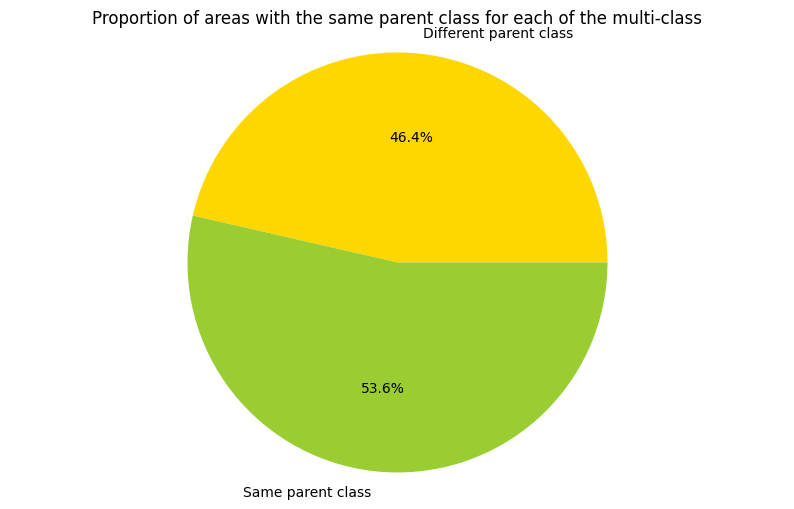

In [167]:
# pie chart of the proportion of areas with the same parent class for each of the multi-class
plt.figure(figsize=(10, 6))
labels = ['Different parent class', 'Same parent class']
sizes = [100 - per_l123_same, per_l123_same]
colors = ['gold', 'yellowgreen']
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%')
plt.axis('equal')
plt.title('Proportion of areas with the same parent class for each of the multi-class')
plt.show()


In [177]:
# keep only the first letter of CDEUNIS_1
filtered_shapefile['CDEUNIS_1'] = filtered_shapefile['CDEUNIS_1'].apply(lambda x: x[0] if isinstance(x, str) else x)
# make the some of shape_area attribute grouping by CDEUNIS_1
grouped = filtered_shapefile.groupby('CDEUNIS_1')['Shape_Area'].sum()
# multiply by total_area and / 100 to get the percentage
grouped = grouped * 100 / total_area

print(grouped)

CDEUNIS_1
1     0.067500
A     0.618986
B     1.144226
C     1.963617
D     0.004133
E    19.015106
F    14.570900
G    28.136969
H     1.036879
I    15.646651
J    12.236097
X     0.096725
Name: Shape_Area, dtype: float64


/home/bertille/.local/lib/python3.8/site-packages/geopandas/geodataframe.py:1472: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


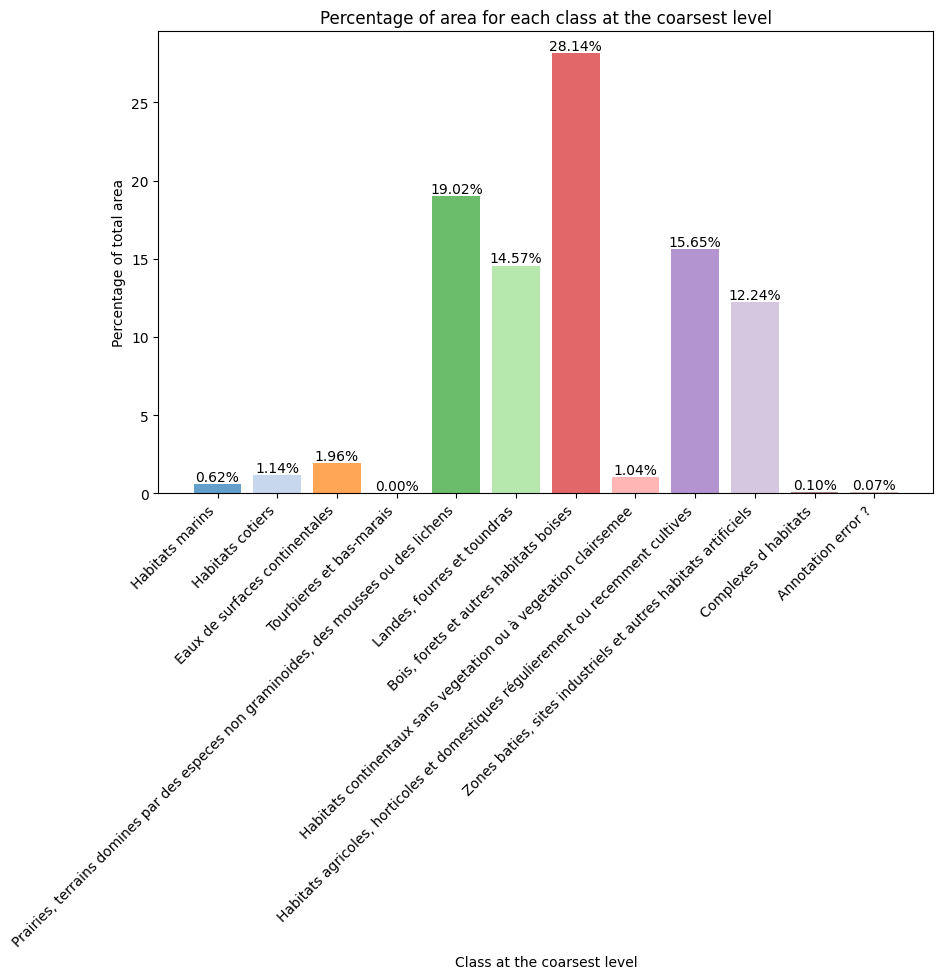

In [190]:
# Sort 'grouped' based on the index order of 'my_classes_l1'
grouped_sorted = grouped.loc[my_classes_l1.keys()]

# Define colors for each class
colors = plt.cm.tab20(np.arange(len(grouped_sorted)))

plt.figure(figsize=(10, 6))
bars = plt.bar(my_classes_l1.values(), grouped_sorted, color=colors, alpha=0.7)
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.2f}%', ha='center', va='bottom')

# Rotate x-ticks diagonally
plt.xticks(rotation=45, ha='right')

plt.title('Percentage of area for each class at the coarsest level')
plt.ylabel('Percentage of total area')
plt.xlabel('Class at the coarsest level')

plt.show()


### Plot one image and its corresponding polygon

In [17]:
# Find how to relate shapefile and tif images

# print nb of unique values in ID column
print('The number of unique values in ID column is ', len(filtered_shapefile['ID'].unique()))
# print nb of unique values in IDETUDE column
print('The number of unique values in IDETUDE column is ', len(filtered_shapefile['IDETUDE'].unique()))

The number of unique values in ID column is  1851
The number of unique values in IDETUDE column is  91


In [40]:
# load BDD_AJ_HABNAT_FINALE2.xlsx
shapefile_tif_link_df = pd.read_excel(data_dir / 'data_1/HABNAT/BDD_AJ_HABNAT_FINALE2.xlsx')
# keep columns id_etude et zone_aj
shapefile_tif_link_df = shapefile_tif_link_df[['id_etude', 'zone_AJ']]

# select one polygon from shapefile with area > 500 and below 600
one_polygon = filtered_shapefile[(filtered_shapefile['Shape_Area'] > 100) & (filtered_shapefile['Shape_Area'] < 3000)].iloc[3]
print(one_polygon[['ID', 'IDETUDE']])
print('The polygon with area > 500 and below 600 has the IDETUDE ', one_polygon['IDETUDE'])

# now let us find its corresponding zone by looking in shapefile_tif_link_df the corresponding zone to its IDETUDE
zone = shapefile_tif_link_df[shapefile_tif_link_df['id_etude'] == one_polygon['IDETUDE']]['zone_AJ']
print('The zone of the polygon with area > 500 and below 600 is ', zone)

ID           22
IDETUDE    2204
Name: 5, dtype: object
The polygon with area > 500 and below 600 has the IDETUDE  2204
The zone of the polygon with area > 500 and below 600 is  Series([], Name: zone_AJ, dtype: object)


In [43]:
# count how many rows have IDETUDE 2204
print('The number of rows with IDETUDE 2204 is ', len(filtered_shapefile[filtered_shapefile['IDETUDE'] == '2204']))
# get the various IDEDUTE available and their proportions
idetudes = filtered_shapefile['IDETUDE'].value_counts(normalize=True)
print(idetudes)

The number of rows with IDETUDE 2204 is  60
IDETUDE
2958                 0.448702
2991                 0.077874
2204                 0.074166
3464                 0.074166
3147                 0.070457
                       ...   
0.029401416015625    0.001236
0.018052880859375    0.001236
0.031002392578125    0.001236
0.163573779296875    0.001236
2.33779              0.001236
Name: proportion, Length: 90, dtype: float64


Almost 50% of the polygons have IDETUDE 2204, so IDETUDE should not be the shared attribute between the zoneid of the tif images and the shapefile.

#### Plot one image and polygon

In [11]:
def plot_image_with_polygon(min_surface_area, filtered_shapefile, intersect_df):
    # Load a shapefile polygon with area > min_surface_area
    filtered_polygon = filtered_shapefile[filtered_shapefile['Shape_Area'] > min_surface_area].iloc[0]

    # Get the path of the TIF image
    tif_path = intersect_df[intersect_df['polygon_index'] == filtered_polygon['index']]['tif_path'].values[0]

    # Open the TIF image
    with rasterio.open(tif_path) as src:
        # Read the image
        img = src.read([1, 2, 3], masked=True)
        # Get image bounds
        tif_bounds = src.bounds

        # Plot the TIF image
        fig, ax = plt.subplots(figsize=(10, 10))
        ax.imshow(img.transpose(1, 2, 0) / 5000, extent=[tif_bounds.left, tif_bounds.right, tif_bounds.bottom, tif_bounds.top])

    # Plot the polygon on top
    polygon = filtered_polygon['geometry']
    gpd.GeoSeries([polygon]).plot(ax=ax, facecolor='none', edgecolor='red')

    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


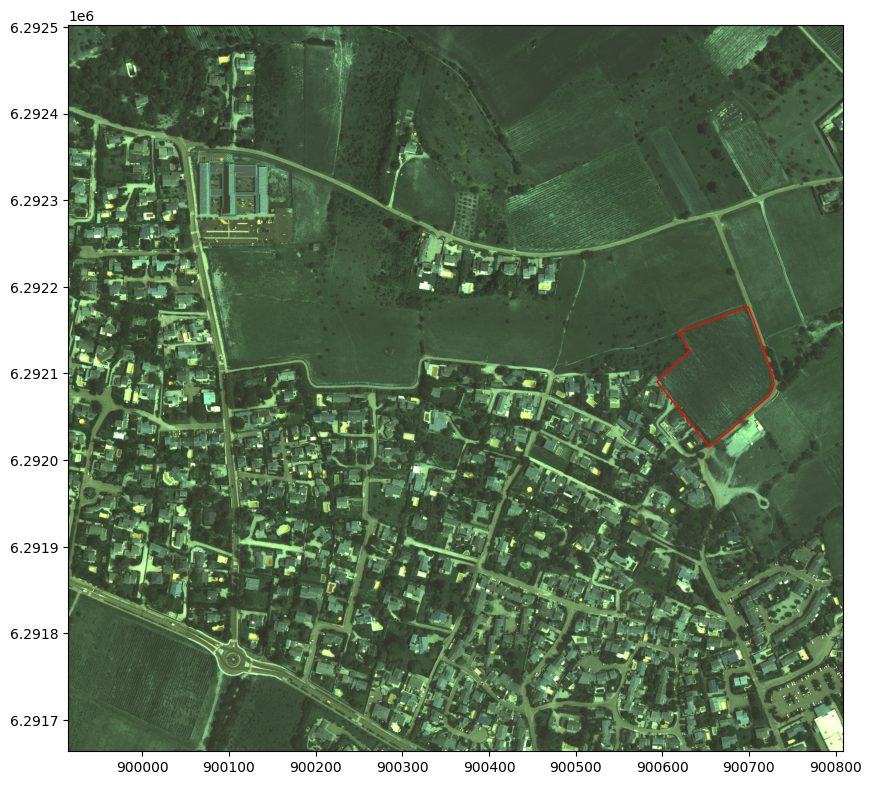

In [12]:
plot_image_with_polygon(1000, filtered_shapefile, intersect_df)

### study finer level than l1

In [20]:
# get all eunis_1 values
eunis_1 = filtered_shapefile['CDEUNIS_1'].unique()
print(eunis_1)
#remove none
eunis_1 = eunis_1[~pd.isnull(eunis_1)]
#truncate after the point
eunis_1 = [x.split('.')[0] for x in eunis_1]
# count max number of characters and print the one with
max_len = max([len(x) for x in eunis_1])
print(max_len)
# print the values with the max length
print([x for x in eunis_1 if len(x) == max_len])

#in filtered_shapefile, change G1131 by G1.131
filtered_shapefile.loc[filtered_shapefile['CDEUNIS_1'] == 'G1131', 'CDEUNIS_1'] = 'G1.131'

# get all eunis_1 values
eunis_1 = filtered_shapefile['CDEUNIS_1'].unique()
#print(eunis_1)
#remove none
eunis_1 = eunis_1[~pd.isnull(eunis_1)]
#truncate after the point
eunis_1 = [x.split('.')[0] for x in eunis_1]
# count max number of characters and print the one with
max_len = max([len(x) for x in eunis_1])
print(max_len)
# print the values with the max length
print([x for x in eunis_1 if len(x) == max_len])

['G5.2' 'J4.2' 'FB.4' 'I1.53' 'E5.13' 'G2.8' 'J2.1' 'I2.3' 'G5.1' 'J2.6'
 'I1.51' 'E1.2A' 'J1.3' 'J1.6' 'G2.91' 'G1.A131' 'E1.61' 'I1.13' 'J1.4'
 'E5.12' 'J1.2' 'C2.3' 'G1.33' 'J5.4' 'F3.22' 'F5.113' 'G1.7C6' 'FA.1'
 'G3.F12' 'J1.51' 'I1.5' 'I2.22' 'G3.7' 'H5.61' 'E1.811' 'G1.312' 'E3.1'
 'C3.32' 'J6.1' 'G1.714' 'E2.7' 'F5.2' 'E3.111' 'F9.3131' 'B1.43' 'G1.31'
 'B2.1' 'C3.31' 'E1.6' 'A2.522' 'J5.2' 'G3.743' 'G2.121' 'J5.33' 'E5.1'
 'J6.4' 'J5.31' 'G3.49' 'G1.7111' 'I1' 'H3.2E5' 'J2.32' 'C3.5' 'C3.21'
 'C2.5' 'G1.334' 'E2.6' 'J6.31' 'G1.C3' 'J4.3' 'J2.5' 'E2.63' 'F6.17'
 'F6.64' 'G1.711' 'E1.51' 'G5.83' 'G1.67' None 'G1.71' 'G3.74' 'E1.31'
 'I1.3' 'I2.21' 'G5.61' 'G1.A29' 'F3.11' 'X23' 'FA.3' 'C1.1' 'E2.8'
 'E1.311' 'G1.D4' 'I1.12' 'J1.41' 'J5' 'F5.11' 'E2.64' 'G1.211' 'G3.57'
 'F3.131' 'G1.1' 'H3.21' 'F6.11' 'H2.62' 'J2.53' 'F6.12' 'E5.14' 'F6.1'
 'G3.72' 'J5.3' 'J5.41' 'J2.31' 'E2.22' 'G5.81' 'F3.1' 'J6' 'G1.A1' 'FA.4'
 'E1.262' 'G1.11' 'E2.222' 'I2.2' 'D5.3' 'E3.511' 'J2.42' 'E2.221'

In [33]:
my_classes_l2 = {
    'A1': 'roche et autres substrats durs intertidaux',
    'A2': 'sédiment intertidal',
    'A3': 'roche et autres substrats durs infralittoraux',
    'A4': 'roche et autres substrats durs circalittoraux',
    'A5': 'sédiment subtidal',
    'A6': 'habitats profonds',
    'A7': 'habitats pélagiques',
    'B1': 'dunes côtières et rivages sableux',
    'B2': 'galets côtiers',
    'B3': 'falaises, corniches et rivages rocheux, incluant le supralittoral',
    'C1': 'eaux dormantes de surface',
    'C2': 'eaux courantes de surface',
    'C3': 'zones littorales des eaux de surface continentales',
    'D1': 'tourbières hautes et tourbières de couverture',
    'D2': 'tourbières de vallée, bas-marais acides et tourbières de transition',
    'D4': 'bas-marais riches en bases et tourbières des sources calcaires',
    'D5': 'roselières sèches et cariçaies, normalement sans eau libre',
    'D6': 'marais continentaux salés et saumâtres et roselières',
    'E1': 'pelouses sèches',
    'E2': 'prairies mésiques',
    'E3': 'prairies humides et prairies humides saisonnières',
    'E4': 'pelouses alpines et subalpines',
    'E5': 'ourlets, clairières forestières et peuplements de grandes herbacées non graminées',
    'E6': 'steppes salées continentales',
    'E7': 'prairies peu boisées',
    'FB': 'plantations d arbustes',
    'F2': 'fourrés arctiques, alpins et subalpins',
    'F3': 'fourrés tempérés et méditerranéo-montagnards',
    'F4': 'landes arbustives tempérées',
    'F5': 'maquis, matorrals arborescents et fourrés thermo-méditerranéens',
    'F6': 'garrigues',
    'F7': 'landes épineuses méditerranéennes (phryganes, landes-hérisson et végétation apparentée des falaises littorales)',
    'F9': 'fourrés ripicoles et des bas-marais',
    'G1': 'forêts de feuillus caducifoliés',
    'G2': 'forêts de feuillus sempervirents',
    'G3': 'forêts de conifères',
    'G4': 'formations mixtes d’espèces caducifoliées et de conifères',
    'G5': 'alignements d’arbres, petits bois anthropiques, boisements récemment abattus, stades initiaux de boisements et taillis',
    'H1': 'grottes, systèmes de grottes, passages et plans d’eau souterrains terrestres',
    'H2': 'éboulis',
    'H3': 'falaises continentales, pavements rocheux et affleurements rocheux',
    'H4': 'habitats dominés par la neige ou la glace',
    'H5': 'habitats continentaux divers sans végétation ou à végétation clairsemée',
    'H6': 'reliefs volcaniques récents',
    'I1': 'cultures et jardins maraîchers',
    'I2': 'zones cultivées des jardins et des parcs',
    'J1': 'bâtiments des villes et des villages',
    'J2': 'constructions à faible densité',
    'J3': 'sites industriels d’extraction',
    'J4': 'réseaux de transport et autres zones de construction à surface dure',
    'J5': 'plans d’eau construits très artificiels et structures connexes',
    'J6': 'dépôts de déchets',
    'X': 'complexes d’habitats'
}

In [30]:
# keep only the first letter of CDEUNIS_1
filtered_shapefile['CDEUNIS_1'] = filtered_shapefile['CDEUNIS_1'].apply(lambda x: x[0:2] if isinstance(x, str) else x)

total_area = filtered_shapefile['Shape_Area'].sum()
# make the some of shape_area attribute grouping by CDEUNIS_1
grouped = filtered_shapefile.groupby('CDEUNIS_1')['Shape_Area'].sum()
# multiply by total_area and / 100 to get the percentage
grouped = grouped * 100 / total_area

print(grouped)

CDEUNIS_1
12     0.067500
A      0.056811
A2     0.562174
B1     1.128587
B2     0.000865
B3     0.014774
C1     0.570555
C2     0.699131
C3     0.693931
D5     0.004133
E1     3.946947
E2     7.497645
E3     0.390546
E5     7.177343
E6     0.002626
F3     1.350042
F5     5.581772
F6     3.371438
F9     1.199354
FA     0.442654
FB     2.625639
G1    10.073708
G2     7.088954
G3     7.941956
G4     0.104517
G5     2.927834
H2     0.007568
H3     0.152879
H5     0.876432
I1    15.328576
I2     0.318075
J      0.020475
J1     4.266726
J2     1.273783
J3     1.412752
J4     3.487573
J5     0.543186
J6     1.231602
X1     0.002317
X2     0.094407
Name: Shape_Area, dtype: float64


/home/bertille/.local/lib/python3.8/site-packages/geopandas/geodataframe.py:1472: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


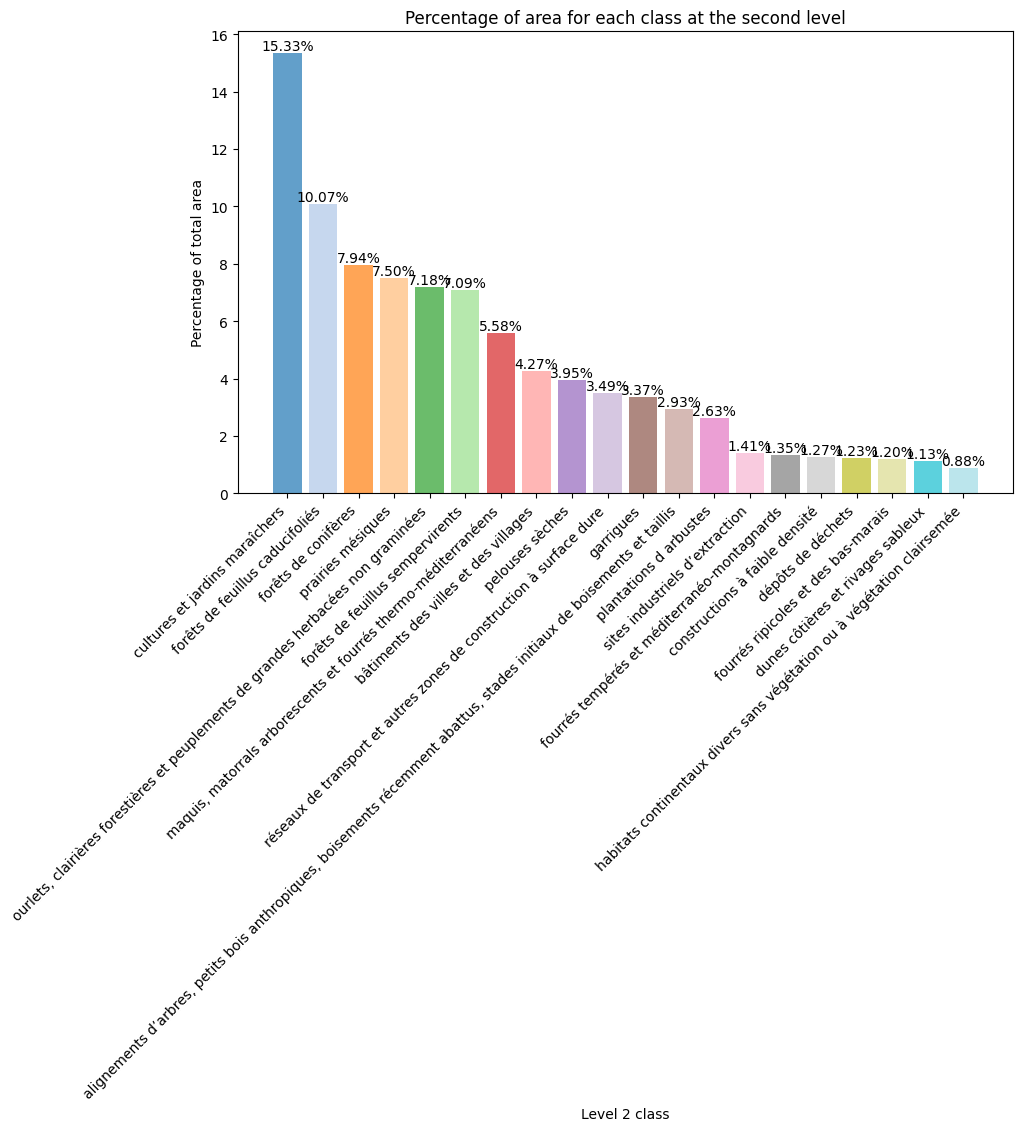

In [35]:
grouped_sorted = grouped.sort_values(ascending=False)

top_20_classes = grouped_sorted.head(20)

percentages = top_20_classes.values
classes = [my_classes_l2[code] for code in top_20_classes.index]

colors = plt.cm.tab20(np.arange(len(top_20_classes)))

plt.figure(figsize=(10, 6))
bars = plt.bar(classes, percentages, color=colors, alpha=0.7)
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.2f}%', ha='center', va='bottom')

plt.xticks(rotation=45, ha='right')

plt.title('Percentage of area for each class at the second level')
plt.ylabel('Percentage of total area')
plt.xlabel('Level 2 class')

plt.show()

